In [16]:
import omnitool
from omnitool.literature_values import *
import barbershop

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
#Lets read in the sample
sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Elsworth_x_TGAS.csv'
columns=['KIC','2MASS','astero_parallax','astero_parallax_err','parallax','parallax_error',\
         'GLAT','GLON','Teff','e_Teff','Dnu','e_Dnu','numax','e_numax',\
        '[M/H]1','e_[M/H]1','kic_kmag','kic_jmag','kic_hmag','stage','numstage']
df = pd.read_csv(sfile,usecols=columns)
df.head(5)

,KIC,astero_parallax,astero_parallax_err,parallax,parallax_error,2MASS,GLAT,GLON,Teff,e_Teff,...,e_Dnu,numax,e_numax,[M/H]1,e_[M/H]1,kic_jmag,kic_hmag,kic_kmag,stage,numstage
0,1162746,0.704225,0.009423,0.952440,0.980712,J19252639+3649116,69.501,9.669,4711.0,84.0,...,0.08,27.98,0.97,-0.49,0.07,9.833,9.272,9.182,RC,1.0
1,1576469,1.236094,0.022919,1.354696,0.278362,J19281017+3706444,70.016,9.315,5004.0,96.0,...,0.16,88.63,2.18,0.10,0.05,8.887,8.444,8.333,2CL,2.0
2,3121940,0.609013,0.011498,0.782023,0.390568,J19304110+3814357,71.266,9.389,4567.0,78.0,...,0.08,27.75,0.95,-0.24,0.06,10.185,9.595,9.483,RC,1.0
3,2303367,1.312336,0.016361,1.447492,0.322575,J19260880+3740242,70.339,9.928,4716.0,76.0,...,0.10,33.59,0.74,0.12,0.05,8.483,7.980,7.834,RC,1.0
4,2988638,0.604961,0.009149,1.135288,0.607884,J19244988+3807300,70.631,10.362,4863.0,86.0,...,0.21,91.21,2.20,0.11,0.05,10.544,10.083,9.945,2CL,2.0


In [84]:
sfile = '/home/oliver/PhD/Catalogues/APOKASC/APOKASC_cat_v3.6.5.txt'
columns= ['KEPLER_ID','2MASS_ID','TEFF_COR_POST','TEFF_COR_ERR',\
          'LOGG_COR_POST','COR_NU_MAX','COR_NU_MAX_ERR',\
          'COR_DELTA_NU','COR_DELTA_NU_ERR','DR12_FE_H_ADOP_COR'\
         'J_MAG_2M','J_MAG_ERR','K_MAG_2M','K_MAG_ERR','H_MAG_2M','H_MAG_ERR',\
         'RA','DEC']
df = pd.read_table(sfile, usecols=columns,skiprows=644,sep='\s+')
print(df.head(0))
print(df['KEPLER_ID'])

ValueError: Usecols do not match names.

In [28]:
#Lets run the scaling relations
sc = omnitool.scalings(df, df.numax, df.Dnu, df. Teff,\
                        _numax_err = df.e_numax, _dnu_err = df.e_Dnu, _Teff_err = df.e_Teff)
df['R'] = sc.get_radius()/Rsol
df['R_err'] = sc.get_radius_err()/Rsol
df['M'] = sc.get_mass()/Msol
df['M_err'] = sc.get_mass_err()/Msol
df['logg'] = sc.get_logg()
df['logg_err'] = sc.get_logg_err()
df['L'] = sc.get_luminosity()/Lsol
df['L_err'] = sc.get_luminosity_err()/Lsol
df['Mbol'] = sc.get_bolmag()
df['Mbol_err'] = sc.get_bolmag_err()

In [47]:
#Lets get the bolometric corrections in K, J, and H
#Per Salaris et al. 1993, [M/H] = [Fe/H] + log(0.638*fa + 0.362)
#where fa is the alpha abundance. We will assume for now that fa = 1
#Therefore, [Fe/H] == [M/H]
df['Z'] = Zsol * 10 ** df['[M/H]1']

get_bc = omnitool.bolometric_correction(df.Teff.values,\
                                       df.logg.values,\
                                       df.L.values,\
                                       df.Z.values)

In [48]:
#Lets get and apply the bolometric corrections
KBC = get_bc(band='Ks')
HBC = get_bc(band='H')
JBC = get_bc(band='J')

100%|██████████| 886/886 [00:00<00:00, 1786.41it/s]


In [50]:
#Calculate absolute magnitudes and appropriate error
df['MKs'] = df.Mbol - KBC
df['MH'] = df.Mbol - JBC
df['MJ'] = df.Mbol - HBC
df['absmag_err'] = np.sqrt(df.Mbol_err**2 + err_bc**2)

Number of seats in use : 1/5.


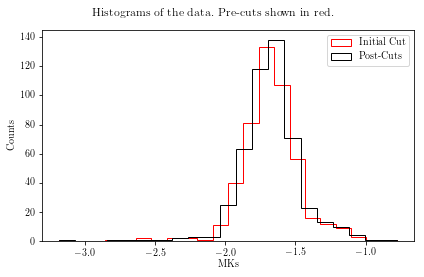

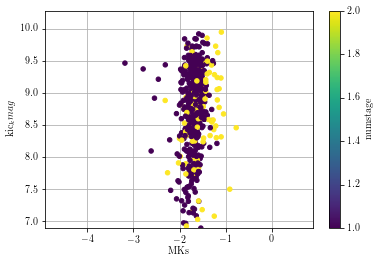

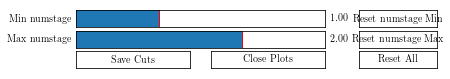

In [62]:
#Lets plot a simple distplot against magnitude
barber = barbershop.open(df,'MKs','kic_kmag')
barber.add_client('numstage',1,2)
barber.histograms_on(x=True)
barber.show_mirror()